In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/homesite-quote-conversion/train.csv.zip
/kaggle/input/homesite-quote-conversion/sample_submission.csv.zip
/kaggle/input/homesite-quote-conversion/test.csv.zip


In [25]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
train = pd.read_csv('/kaggle/input/homesite-quote-conversion/train.csv.zip')
test = pd.read_csv('/kaggle/input/homesite-quote-conversion/test.csv.zip')

# Intro

**Background**

For insurance companies, quote conversion is a measure of the success rate a company achieves of converting quote for business into actual policies. It is an important measure in the insurance industry to develop a conversion rate model to provide confidence that a quoted price will lead to a policy purchase. 

This is a binary classification problem where the task is to predict QuoteConversion_Flag for each Quote Number in the test set.



**Goal**

Using an anonymized database of information on customer and sales activity, including property and coverage information, the goal is to predict which customers will purchase a given quote. Accurately predicting conversion would help Homesite better understand the impact of proposed pricing changes and maintain an ideal portfolio of customer segments.

Our task is to a model to predict whether the quote given by Homesite to a customer will end up in a successful conversion or not.

As part of the goal is to maintain an ideal portfolio of customer segments, high interpretability of the model is ideal as it will provide Homesite with better insight into what factors are most affecting conversions.


# Exploratory Data Analysis

Homesite provided a train and test dataset. 

The train dataset is roughly 40 MB in size and test is roughly 20 MB in size. 

The data is all from one table. 

In [27]:
print(train.shape)
print(test.shape)

(260753, 299)
(173836, 298)


In [28]:
train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,...,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,...,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,...,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,...,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,...,18,22,-1,10,-1,11,-1,12,N,IL


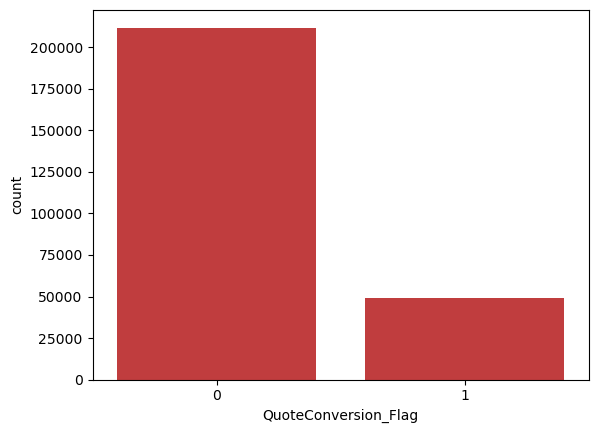

In [29]:
# Plot target variable conversion flag

color=sns.color_palette()[3]
sns.countplot(x=train['QuoteConversion_Flag'],color=color);


In [30]:
# Get conversion rate train 
train_converted = train[train['QuoteConversion_Flag'] == 1]
conversion_rate = len(train_converted)/len(train)
print('Conversion rate:', conversion_rate)

Conversion rate: 0.1875107860695754


In [31]:
train.dtypes

QuoteNumber              int64
Original_Quote_Date     object
QuoteConversion_Flag     int64
Field6                  object
Field7                   int64
                         ...  
GeographicField61B       int64
GeographicField62A       int64
GeographicField62B       int64
GeographicField63       object
GeographicField64       object
Length: 299, dtype: object

In [32]:
train.corr()

,QuoteNumber,QuoteConversion_Flag,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,...,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B
QuoteNumber,1.000000,-0.002250,0.000685,0.000127,-0.002208,0.002324,0.001716,0.002678,0.001521,0.002236,...,-0.001315,-0.001129,-0.001472,-0.001652,-0.000882,-0.001120,0.001470,-0.000658,0.002361,-0.000799
QuoteConversion_Flag,-0.002250,1.000000,-0.137532,0.127039,0.179569,-0.100376,-0.076398,-0.070245,-0.072644,-0.065846,...,-0.001477,-0.001302,0.063788,0.068792,0.014200,0.012505,0.004799,0.038513,-0.003142,-0.017524
Field7,0.000685,-0.137532,1.000000,-0.436411,-0.572369,-0.256320,0.047157,0.044923,0.045087,0.042424,...,0.056158,0.055686,-0.123446,-0.138638,-0.019610,-0.071154,0.024822,0.024157,0.032390,0.077039
Field8,0.000127,0.127039,-0.436411,1.000000,0.710963,0.127229,-0.018017,-0.008386,-0.018319,-0.008816,...,-0.048556,-0.047126,0.173892,0.192334,0.039526,0.080491,-0.005744,0.050124,-0.034117,-0.092827
Field9,-0.002208,0.179569,-0.572369,0.710963,1.000000,0.144041,-0.024764,-0.013950,-0.023559,-0.012915,...,-0.074914,-0.073524,0.206482,0.230587,0.042067,0.105938,-0.021204,0.025639,-0.048947,-0.126171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GeographicField60B,-0.001120,0.012505,-0.071154,0.080491,0.105938,0.025176,0.428831,0.454438,0.430338,0.455234,...,-0.268569,-0.272638,0.307047,0.318225,0.266168,1.000000,-0.153296,-0.324628,-0.066766,-0.185878
GeographicField61A,0.001470,0.004799,0.024822,-0.005744,-0.021204,-0.052240,-0.084134,-0.094136,-0.085625,-0.095739,...,0.094346,0.085568,-0.062171,-0.064494,-0.023254,-0.153296,1.000000,0.269318,0.093504,0.083706
GeographicField61B,-0.000658,0.038513,0.024157,0.050124,0.025639,-0.191950,-0.171075,-0.179718,-0.172943,-0.181424,...,0.204034,0.205978,-0.130358,-0.133507,-0.092942,-0.324628,0.269318,1.000000,0.045051,0.112729
GeographicField62A,0.002361,-0.003142,0.032390,-0.034117,-0.048947,-0.000877,-0.053109,-0.061756,-0.055228,-0.064057,...,-0.012236,-0.014694,0.042296,0.029642,-0.008459,-0.066766,0.093504,0.045051,1.000000,0.300912


In [33]:
print(np.array(train.isnull().any()))
null_columns = train.columns[train.isnull().any()]
null_columns


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False  T

Index(['PersonalField7', 'PersonalField84', 'PropertyField3', 'PropertyField4',
       'PropertyField29', 'PropertyField32', 'PropertyField34',
       'PropertyField36', 'PropertyField38'],
      dtype='object')

In [34]:
# Get number of categorical features
num_cat_features = train.select_dtypes(include=['object']).shape[1]

# Get number of numeric features
num_num_features = train.select_dtypes(include=['int64', 'float64']).shape[1]
# Subtract 1 because of the target 
num_num_features = num_num_features - 1

print("Number of categorical features:", num_cat_features)
print("Number of numeric features:", num_num_features)

Number of categorical features: 28
Number of numeric features: 270


In [35]:
null_columns_test = test.columns[test.isnull().any()]
null_columns_test

Index(['PersonalField7', 'PersonalField84', 'PropertyField3', 'PropertyField4',
       'PropertyField5', 'PropertyField29', 'PropertyField30',
       'PropertyField32', 'PropertyField34', 'PropertyField36',
       'PropertyField38'],
      dtype='object')

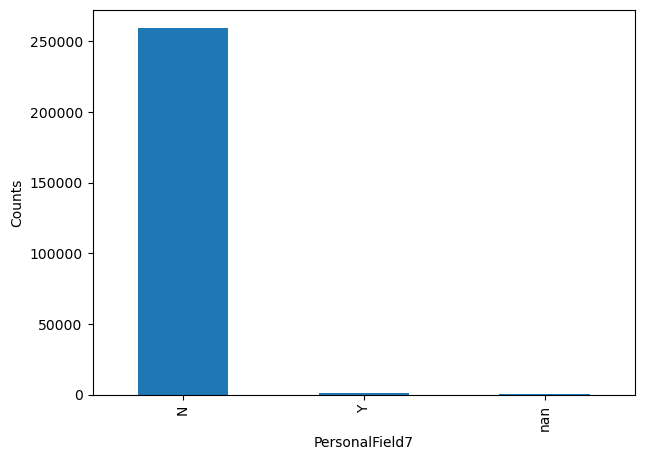

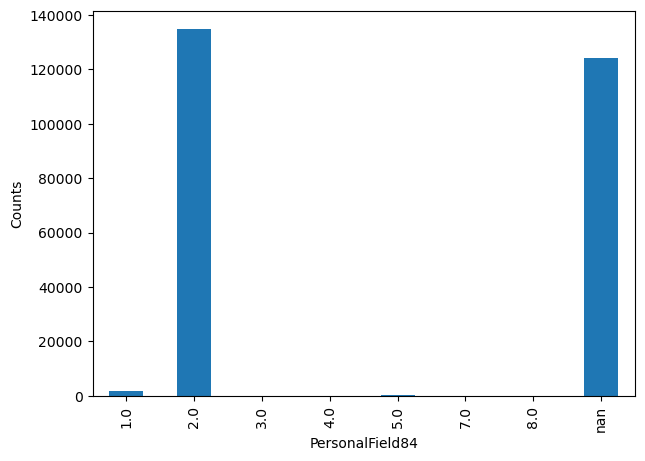

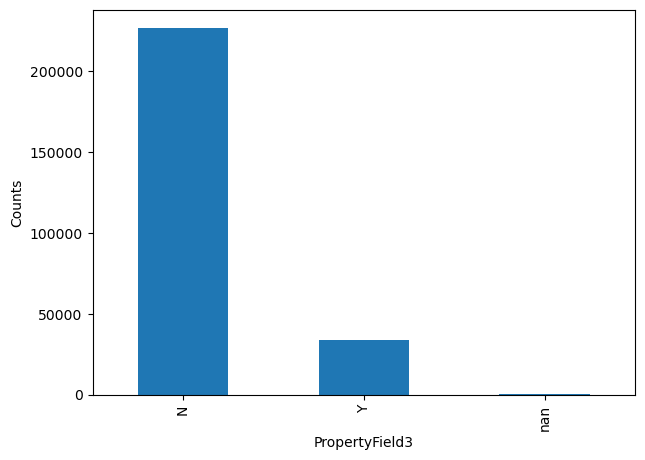

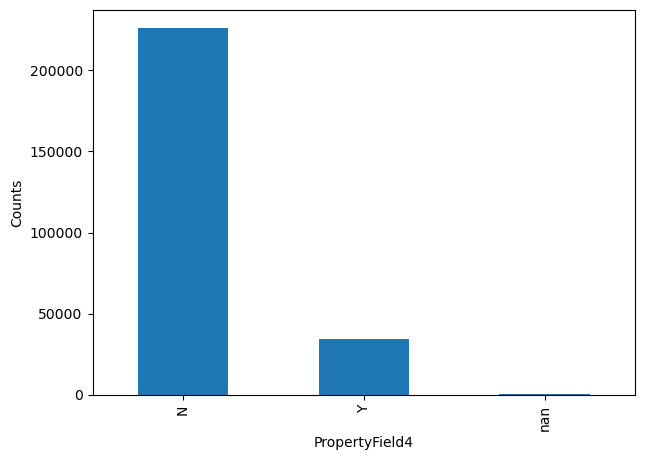

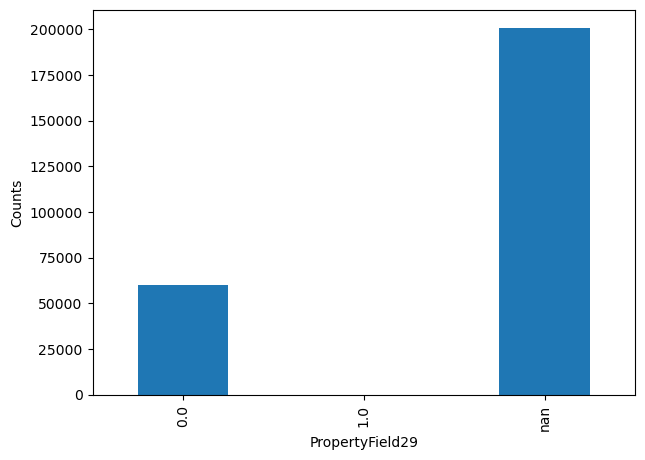

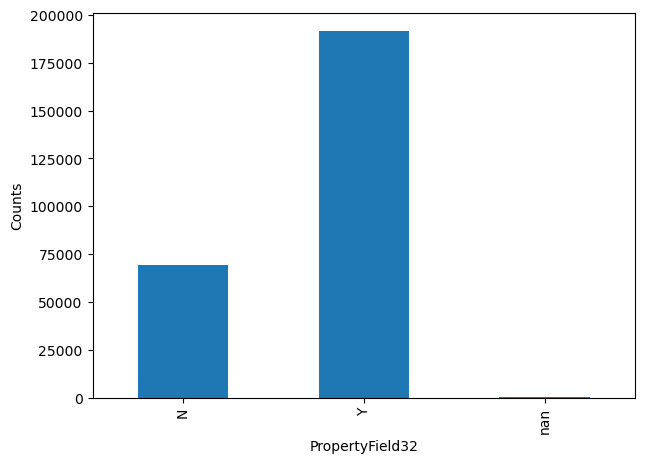

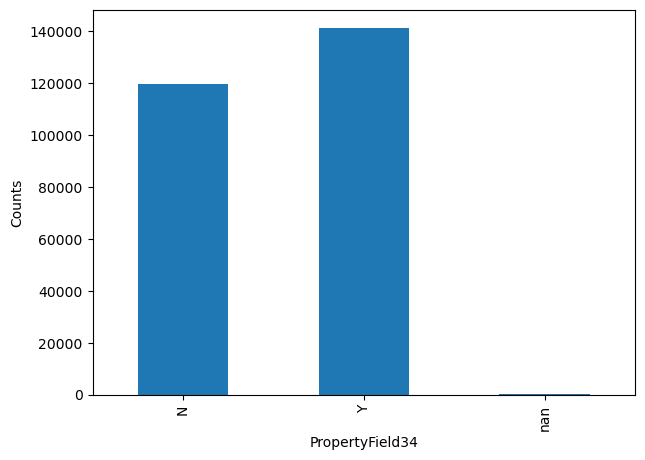

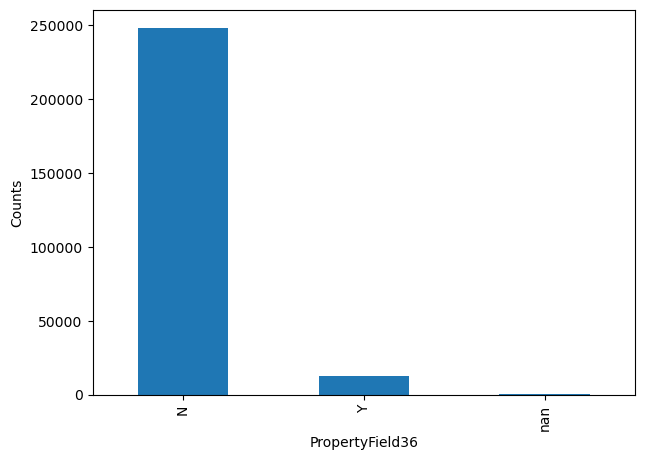

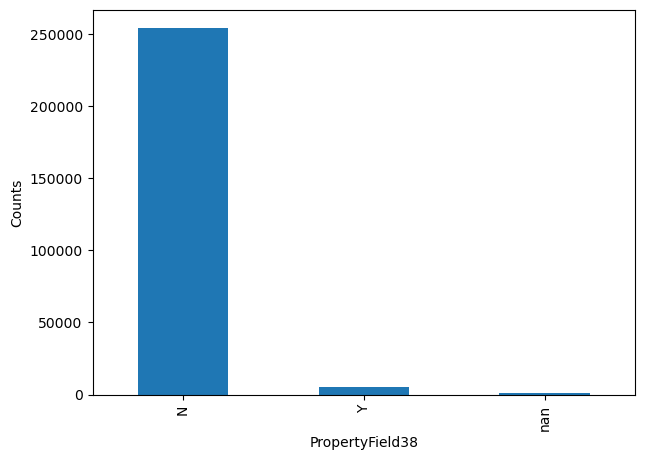

In [36]:
for col in null_columns:
    plt.figure(figsize=(7,5))
    train[col].value_counts(dropna=False).sort_index().plot(kind='bar')    
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.show()

# Data Cleaning

In [37]:
# Drop columns where there is high null count or having only 1 value
train.drop(columns=['PersonalField7', 'PersonalField84', 'PropertyField3', 'PropertyField4',
                'PropertyField29', 'PropertyField32', 'PropertyField34',
                'PropertyField36', 'PropertyField38',
                'GeographicField10A','PropertyField6'], axis=1,inplace=True)

test.drop(columns=['PersonalField7', 'PersonalField84', 'PropertyField3', 'PropertyField4',
                'PropertyField29', 'PropertyField32', 'PropertyField34',
                'PropertyField36', 'PropertyField38',
                'GeographicField10A','PropertyField6'], axis=1,inplace=True)


In [38]:
for col in train.columns:
    if train[col].dtype == 'object':
        train[col].fillna(train[col].mode()[0], inplace=True)
    else:
        train[col].fillna(train[col].mean(), inplace=True)
        
for col in test.columns:
    if train[col].dtype == 'object':
        train[col].fillna(train[col].mode()[0], inplace=True)
    else:
        train[col].fillna(train[col].mean(), inplace=True)

In [39]:
for i in ['year','month','day']:
     train[i] = np.nan
     test[i] = np.nan

train[['year','month','day']] = list(train.Original_Quote_Date.str.split("-"))
test[['year','month','day']] = list(test.Original_Quote_Date.str.split("-"))

In [40]:
# Store the test quote numbers
quote_numbers = test.QuoteNumber

# Drop the ID and QuoteNumber as the QuoteNumber has already been split into 3 columns
train.drop(['Original_Quote_Date','QuoteNumber'],axis=1,inplace=True)
test.drop(['Original_Quote_Date', 'QuoteNumber'],axis=1,inplace=True)

In [41]:
X = train.drop('QuoteConversion_Flag',axis=1)
y = train.QuoteConversion_Flag


In [42]:
# Label encode categorical columns

for f in train.columns:
    if train[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

Field6
Field10
Field12
CoverageField8
CoverageField9
SalesField7
PersonalField16
PersonalField17
PersonalField18
PersonalField19
PropertyField5
PropertyField7
PropertyField14
PropertyField28
PropertyField30
PropertyField31
PropertyField33
PropertyField37
GeographicField63
GeographicField64
year
month
day


In [43]:
X = train.drop('QuoteConversion_Flag',axis=1)
y = train.QuoteConversion_Flag

# Feature Selection

In [44]:
from sklearn import feature_selection
from sklearn.feature_selection import mutual_info_classif

model = xgb.XGBClassifier()
model.fit(X, y)

# get the feature importance
importance = model.feature_importances_

# get the 50 most important features
most_important_features = np.argsort(importance)[-50:]
most_important_features

array([195,   0,  39, 186, 200,  48, 114, 249, 122,  44, 159, 155, 139,
       206, 197, 169, 179,  30,  83, 182,  25, 170,  54,  27, 127,  34,
        42,  17,  19,  49,  28, 156,  63, 189,  50,   3, 148,  23,  64,
        52,  24, 119, 174,   1,  40,  51,  47,  41,  29, 157])

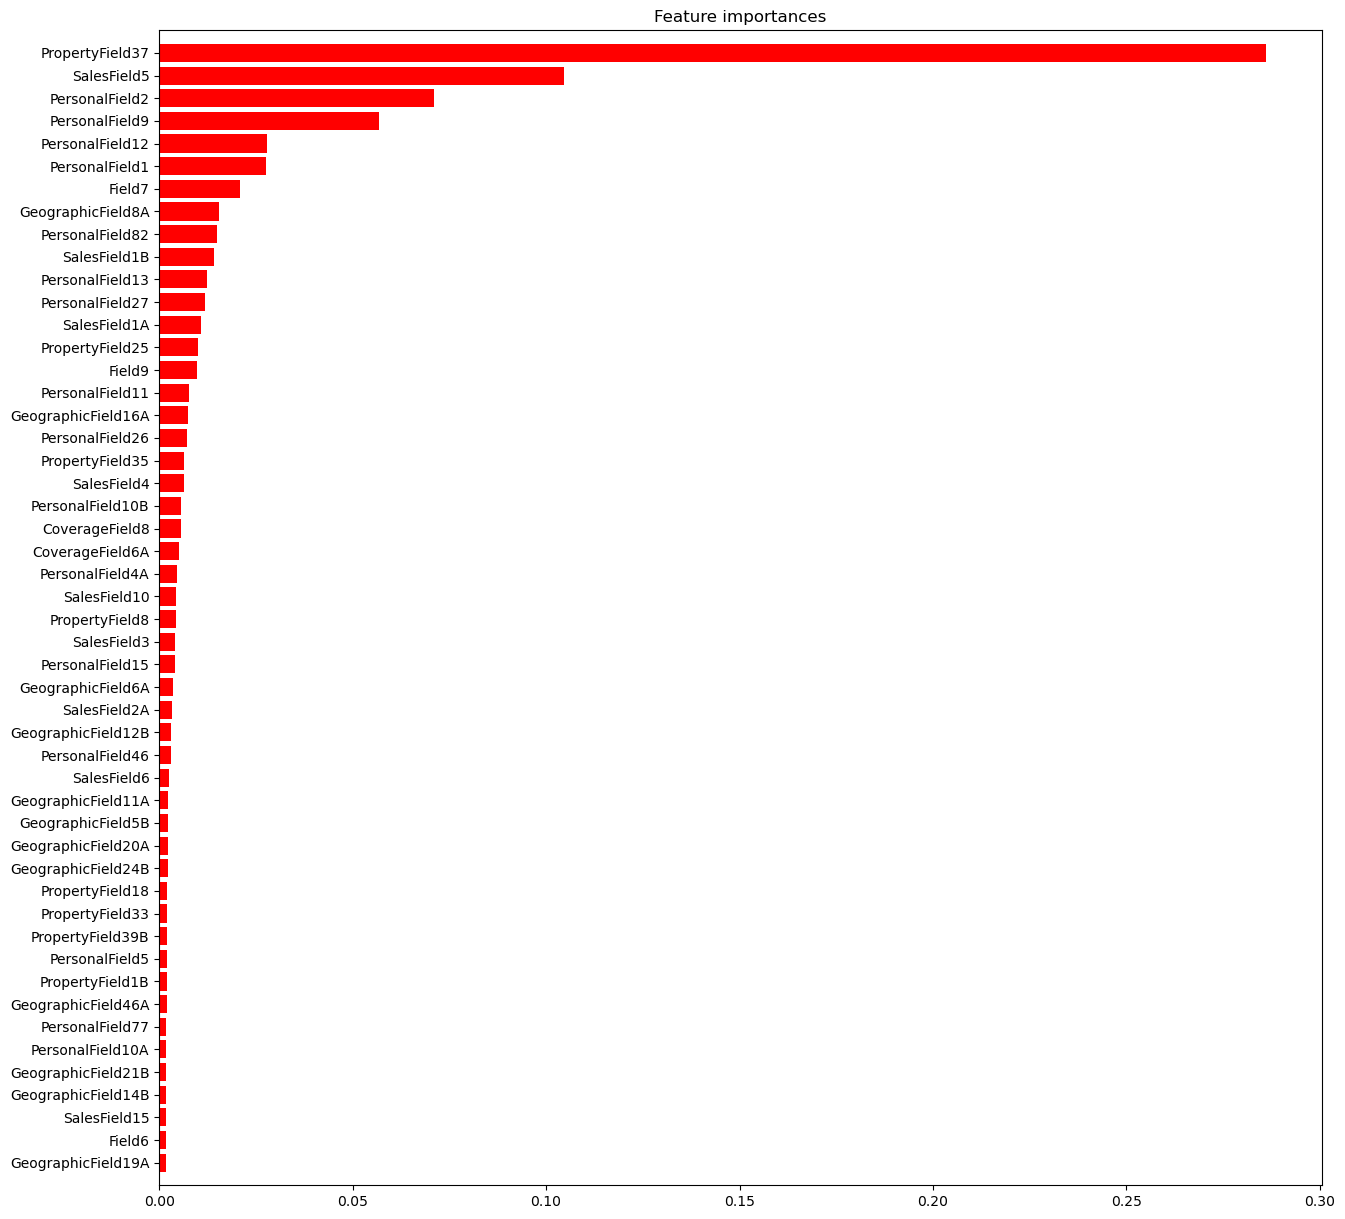

In [45]:
# get the names of the 50 most important features
names = [X.columns[i] for i in most_important_features]
names

# plot the 50 most important features
plt.figure(figsize=(15, 15))
plt.title("Feature importances")
plt.barh(range(len(most_important_features)), importance[most_important_features],
         color="r", align="center")
plt.yticks(range(len(most_important_features)), names)
plt.ylim([-1, len(most_important_features)])
plt.show()

# Model Creation

In [50]:
train = train[names]
test = test[names]

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)


model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Score model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.58%


In [51]:
# Make predictions for test data
y_pred = model.predict(test)
predictions = [round(value) for value in y_pred]



In [52]:
# Create submission file
submission = pd.DataFrame({ 'QuoteNumber': quote_numbers,
                            'QuoteConversion_Flag': predictions })
submission.to_csv("submission.csv", index=False)

# Conclusion

Given the nature of the dataset, it is difficult to select features based on domain knowledge due to the fact that no descriptions were given for what the property or geographical features were. 

Instead, we used XGB to estimate feature importance of our dataset. 

Potential improvements could be made by selecting a different number of features to train the data on. A large improvement could be made if the data were not anonymous and domain knowledge could be used to improve the model. 